In [158]:
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib
from matplotlib import pyplot as plt
from textwrap import wrap


pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)

import pickle
import time
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb

from itertools import product

#import googletrans
#from googletrans import Translator
#to avoid instantiate too many translator, we created one instance for the whole notebook
#translator = Translator()

random_key=42

import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
#from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 

from sklearn.ensemble import RandomForestClassifier

import shap

In [159]:
# The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, F1 score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and P-R curve
# 5. plot feature importance list

def run_model(gs, model_name, X_train, y_train, X_validation, y_validation):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    # print(gs.best_params_)
    if isinstance(gs, GridSearchCV):
        print("best_params: ")
       # print(gs.best_params_, best_lgb.best_score_)
        for (item, value) in gs.best_params_.items():
            print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_rmse_score = gs.score(X_train, y_train) * (-1)
    validation_rmse_score = gs.score(X_validation, y_validation) * (-1)
    rmse_perc_diff = np.abs(validation_rmse_score/train_rmse_score*100-100)
    
    print(f'\nrmse_score on training set: {train_rmse_score:.3f}')
    print(f'rmse_score on testing set: {validation_rmse_score:.3f}')
    print(f'perc_diff: {rmse_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_validation_preds = gs.predict(X_validation)
    
    # only plot the important feature list if the model is instance of (gridsearchcv)
    if isinstance(gs,GridSearchCV):
        # plot featureimportances
        #model = gs.best_estimator_.named_steps["classifier"]
        model = gs.best_estimator_
        importances = model.feature_importances_
        indices = np.argsort(importances)
        fig,ax=plt.subplots(1,figsize=(7,12))
        features = X_train.columns
        plt.title('Feature Importance')
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    

    return pd.DataFrame({'rmse_score on training set': train_rmse_score,
                         'rmse_score on testing set': validation_rmse_score,
                         'Generalization %': rmse_perc_diff,
                        }, index=[model_name])

# import data from pickle file

In [160]:
#read pickle_dict, which store everything

pickle_dict1 = pickle.load(open('../temp/data1.pkl', 'rb'))
df_all = pickle_dict1['df_all']   #concat df_train_m and df_test
df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_items = pickle_dict1['df_items']
df_shops = pickle_dict1['df_shops']
df_cat = pickle_dict1['df_cat']
new_arrival_item_list = pickle_dict1['new_arrival_item_list']


pickle_dict2 = pickle.load(open('../temp/data2.pkl', 'rb'))
df_basegrid = pickle_dict2['df_basegrid']   #concat df_train_m and df_test


In [161]:
df_basegrid.shape

(2946018, 10)

In [162]:
df_basegrid.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,is_new_arrival,month,year,year_month,item_category_id
0,2,5572,0,"1,533.00",9,0,1,2013,2013-01-01,2
1,2,5643,0,"2,388.00",0,0,1,2013,2013-01-01,2
2,2,5583,0,594.00,2,0,1,2013,2013-01-01,5
3,2,7893,0,"1,990.00",3,0,1,2013,2013-01-01,6
4,2,7894,0,"1,490.00",1,0,1,2013,2013-01-01,6


In [163]:
df_items.head()

,item_name,item_id,item_category_id
0,! IN THE POWER OF GLAMOR (PLAST.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full [PC Digital],1,76
2,*** IN THE RAYS OF GLORY (UNV) D,2,40
3,***BLUE WAVE (Univ) D,3,40
4,***BOX (GLASS) D,4,40


# Feature Engineering

In [164]:
df_temp = df_basegrid


#feature engineerinf flag, it controls which featurs to be added to final feature list
fe_flag=[ 1, #0, item name
          1, #1, item category name
          0, #2, shop name
          0, #3, release month of item in the shop
          1, #4, lagged item_cnt_month
          1, #5, lagged monthly all-shop sales for each item
          0, #6, Number of month from last sale of shop/item (Use info from past)
          
]

#hold the features to be added to final selection
#dict_final_selected_features={}
list_new_features = []

# Some parameters(maybe add more periods, score will be better) [1,2,3,12]
lookback_range = [1,2,3,4,5,6,7,8,9,10,11,12]


In [165]:
############################ 0 item name feature engineering
##################################################################
if fe_flag[0] == 1:
    #list_feature_item_name =[]
    #df_temp = df_basegrid.merge(df_items, on=['item_id', 'item_category_id'])
    #list_feature_item_name.append('item_name')
    #print(list_feature_item_name)

    #dict_final_selected_features[0]=list_feature_item_name
    
    items_subset = df_items[['item_id', 'item_name']]
    feature_count = 10
    tfidf = TfidfVectorizer(max_features=feature_count)
    items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

    cols = items_df_item_name_text_features.columns
    for i in range(feature_count):
        feature_name = 'item_name_tfidf_' + str(i)
        items_subset[feature_name] = items_df_item_name_text_features[cols[i]]
        list_new_features.append(feature_name)

    items_subset.drop('item_name', axis = 1, inplace = True)
    df_temp = df_temp.merge(items_subset, on = 'item_id', how = 'left')
    df_temp.head()


In [166]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
 2   unique_item_num     84 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


In [167]:
############################## 1 item category feature engineering
#####################################################################
if fe_flag[1] == 1: 
    
#"""    
    cat_subset = df_cat[['item_category_id', 'item_category_name']]
    feature_count = 15
    tfidf = TfidfVectorizer(max_features=feature_count)
    df_cat_name_text_features = pd.DataFrame(tfidf.fit_transform(cat_subset['item_category_name']).toarray())

    cols = df_cat_name_text_features.columns
    for i in range(feature_count):
        feature_name = 'cat_name_tfidf_' + str(i)
        cat_subset[feature_name] = df_cat_name_text_features[cols[i]]
        list_new_features.append(feature_name)

    cat_subset.drop('item_category_name', axis = 1, inplace = True)
    df_temp = df_temp.merge(cat_subset, on = 'item_category_id', how = 'left')
    df_temp.head()
#"""



In [168]:
########################## 2 shop feature engineering
###################################################################
if fe_flag[2] == 1:
    list_feature_shop_name=[]
    df_temp =df_temp.merge(df_shops, on='shop_id')
    list_feature_shop_name=['shop_name']
    dict_final_selected_features[2]=list_feature_shop_name

In [169]:
############################# 3 release month of item in the shop
#####################################################################
if fe_flag[3] == 1:
    list_feature_shop_name=[]
    df_temp =df_temp.merge(df_shops, on='shop_id')
    list_feature_shop_name=['shop_name']
    dict_final_selected_features[2]=list_feature_shop_name



In [170]:
############################### 4 lagged item_cnt_month
######################################################################
if fe_flag[4] == 1:
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_sales_' + str(diff)
        trainset2 = df_temp.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        df_temp = df_temp.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
        list_new_features.append(feature_name)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.01s/it]


In [171]:
############################# 5 lagged monthly all-shop sales for each item
######################################################################
if fe_flag[5] == 1:
    groups = df_temp.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_sales_' + str(diff)
        result = groups.agg({'item_cnt_month':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        df_temp = df_temp.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
        list_new_features.append(feature_name)      


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.57s/it]


In [172]:
############################# 6 Number of month from last sale of shop/item (Use info from past)
######################################################################
def create_last_sale_shop_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan



if fe_flag[6] == 1:
    lookback_range = list(range(1, 33 + 1))
    for diff in tqdm(lookback_range):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        trainset2 = df_temp.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        df_temp = df_temp.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
            #new_features.append(feature_name)

    df_temp.loc[:, 'last_sale_shop_item'] = df_temp.apply (lambda row: create_last_sale_shop_item(row),axis=1)
    list_new_features.append('last_sale_shop_item')


# data pre-preparation

In [173]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946018 entries, 0 to 2946017
Data columns (total 59 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   shop_id                 int8          
 1   item_id                 int16         
 2   date_block_num          int8          
 3   item_price              float16       
 4   item_cnt_month          int16         
 5   is_new_arrival          int8          
 6   month                   int8          
 7   year                    int16         
 8   year_month              datetime64[ns]
 9   item_category_id        int8          
 10  item_name_tfidf_0       float64       
 11  item_name_tfidf_1       float64       
 12  item_name_tfidf_2       float64       
 13  item_name_tfidf_3       float64       
 14  item_name_tfidf_4       float64       
 15  item_name_tfidf_5       float64       
 16  item_name_tfidf_6       float64       
 17  item_name_tfidf_7       float64       
 18  it

In [181]:

list_feature_base = ['shop_id','item_id', 'item_category_id','date_block_num',
                     'month','year','is_new_arrival', 
                     'item_cnt_month'
                 ]

list_feature_final =   list_new_features + list_feature_base
print(list_feature_final)


df_final = df_temp[list_feature_final]
#df_y_final = df_temp['item_cnt_month']
#y_final = df_temp['item_cnt_month']


validation_date_block_num= 33   #'1-10-2015'
test_date_block_num = 34        #'1-11-2015'


index_train = (df_final['date_block_num'] < validation_date_block_num)
df_train_final = df_final[index_train]

index_validation = (df_final['date_block_num'] == validation_date_block_num)
df_validation_final = df_final[index_validation]


index_test = (df_final['date_block_num'] == test_date_block_num)
df_test_final = df_final[index_test]



X_train =  df_train_final.iloc[:, 0:-1]
y_train =  df_train_final.iloc[:, -1]
print('\nprinting X_train.columns')
print(X_train.columns)

print('\nprinting y_train.info()')
print(y_train.info())

X_validation = df_validation_final.iloc[:, 0:-1]
y_validation =  df_validation_final.iloc[:, -1]

X_test =  df_test_final.iloc[:, 0:-1]
y_test =  df_test_final.iloc[:, -1]


####TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=2)

['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2', 'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5', 'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8', 'item_name_tfidf_9', 'cat_name_tfidf_0', 'cat_name_tfidf_1', 'cat_name_tfidf_2', 'cat_name_tfidf_3', 'cat_name_tfidf_4', 'cat_name_tfidf_5', 'cat_name_tfidf_6', 'cat_name_tfidf_7', 'cat_name_tfidf_8', 'cat_name_tfidf_9', 'cat_name_tfidf_10', 'cat_name_tfidf_11', 'cat_name_tfidf_12', 'cat_name_tfidf_13', 'cat_name_tfidf_14', 'prev_shopitem_sales_1', 'prev_shopitem_sales_2', 'prev_shopitem_sales_3', 'prev_shopitem_sales_4', 'prev_shopitem_sales_5', 'prev_shopitem_sales_6', 'prev_shopitem_sales_7', 'prev_shopitem_sales_8', 'prev_shopitem_sales_9', 'prev_shopitem_sales_10', 'prev_shopitem_sales_11', 'prev_shopitem_sales_12', 'prev_item_sales_1', 'prev_item_sales_2', 'prev_item_sales_3', 'prev_item_sales_4', 'prev_item_sales_5', 'prev_item_sales_6', 'prev_item_sales_7', 'prev_item_sales_8', 'prev_item_sa

list_final_selected_features = []

for i in range(len(fe_flag)):
    if fe_flag[i]==1:
        list_final_selected_features +=  dict_final_selected_features[i]
        

print(list_final_selected_features)


In [176]:
print(list_feature_final)

['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2', 'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5', 'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8', 'item_name_tfidf_9', 'cat_name_tfidf_0', 'cat_name_tfidf_1', 'cat_name_tfidf_2', 'cat_name_tfidf_3', 'cat_name_tfidf_4', 'cat_name_tfidf_5', 'cat_name_tfidf_6', 'cat_name_tfidf_7', 'cat_name_tfidf_8', 'cat_name_tfidf_9', 'cat_name_tfidf_10', 'cat_name_tfidf_11', 'cat_name_tfidf_12', 'cat_name_tfidf_13', 'cat_name_tfidf_14', 'prev_shopitem_sales_1', 'prev_shopitem_sales_2', 'prev_shopitem_sales_3', 'prev_shopitem_sales_4', 'prev_shopitem_sales_5', 'prev_shopitem_sales_6', 'prev_shopitem_sales_7', 'prev_shopitem_sales_8', 'prev_shopitem_sales_9', 'prev_shopitem_sales_10', 'prev_shopitem_sales_11', 'prev_shopitem_sales_12', 'prev_item_sales_1', 'prev_item_sales_2', 'prev_item_sales_3', 'prev_item_sales_4', 'prev_item_sales_5', 'prev_item_sales_6', 'prev_item_sales_7', 'prev_item_sales_8', 'prev_item_sa

### Baseline Model : Previous Month Sale
- score: 1.16777

################# Baseline benchmark: Previous Value 
####################################################

df_valid_test = df_test.merge(df_validation_final,on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month"]]

#score: 1.16777
df_valid_test['item_cnt_month'] = df_valid_test.item_cnt_month.fillna(0).clip(0,20)
submission = df_valid_test.set_index('ID')
submission.to_csv('benchmark.csv')


#### Model: XGB + ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_cnt_month']

- score: 1.16655

%%time
model_xgb = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, 
                         subsample = 1, eta = 0.3, seed = 1,eval_metric='rmse')
model_xgb.fit(X_train, y_train)


y_validation_preds = model_xgb.predict(X_validation)
rmse = mean_squared_error(y_validation, y_validation_preds, squared=False)
print("rmse = ", rmse)



#### Model: LGBM + ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_cnt_month']

- Score: 1.12633
- add item name: Score: 1.24876
- add item name,cat name: Score: 1.12528
- add item name,cat name, lagged shop/item sales, score: 1.02569
- add item name,cat name, lagged shop/item sales, lagged item/allshop sales: Score: 0.99791, reconciled score: 0.98947

best_params: 
    reg_alpha  :  0.5

rmse_score on training set: 2.295
rmse_score on testing set: 1.943
perc_diff: 15.3 %



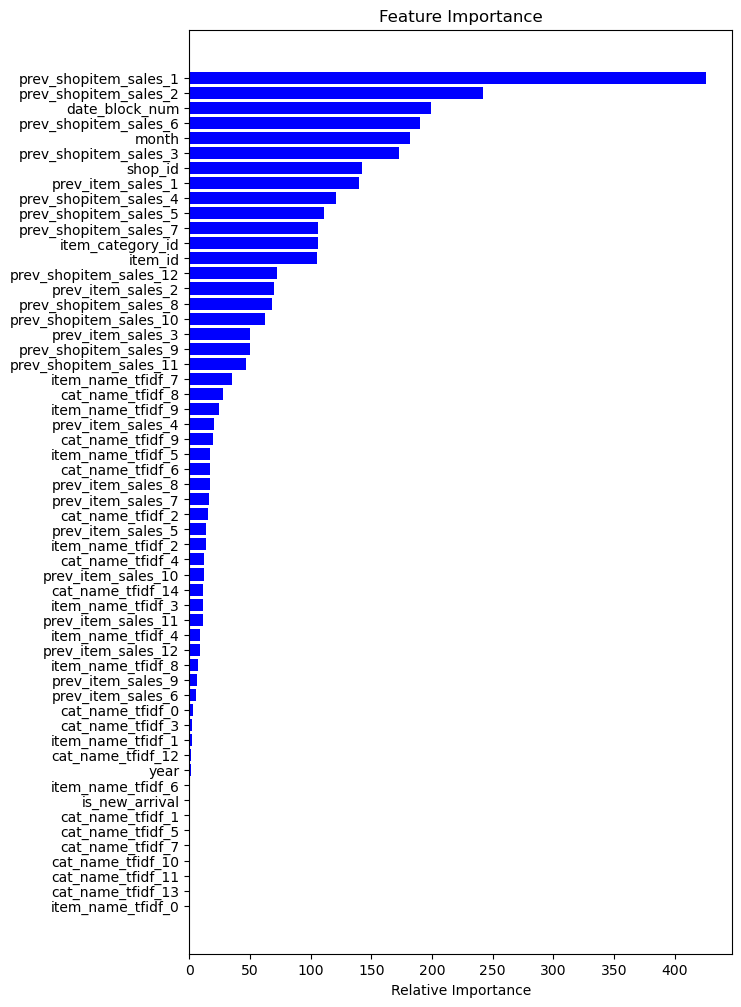

Wall time: 1min 49s


,rmse_score on training set,rmse_score on testing set,Generalization %
LightGBM,2.30,1.94,15.34


In [182]:
%%time
model =lgb.LGBMRegressor(random_state=random_key)

param_grid = {
    #'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    #'min_data_in_leaf': [30, 50, 100, 300, 400],
    #'lambda_l1': [0, 1, 1.5],
    #'lambda_l2': [0, 1]
    }

gs_lgb = GridSearchCV(estimator=model, 
                      param_grid=param_grid,
                      scoring = 'neg_root_mean_squared_error',
                      cv=tscv,
                      n_jobs = -1
                     )

run_model(gs_lgb, 'LightGBM', X_train, y_train, X_validation, y_validation)

#best_lgb = gs_lgb.fit(X=X_train, y=y_train)
#print(best_lgb.best_params_, best_lgb.best_score_)
#y_validation_preds = best_lgb.predict(X_validation)
#rmse = mean_squared_error(y_validation, y_validation_preds, squared=False)
#print("rmse = ", rmse)



# production model and make predictions

In [178]:
production_model = gs_lgb.best_estimator_




#### Shap


shap_values = shap.TreeExplainer(production_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# pickle test_preds for model reconciliation

In [179]:
df_test_preds = df_test_final
df_test_preds['item_cnt_month'] = production_model.predict(X_test)

pickle_dict_preds = dict()
pickle_dict_preds['df_test_preds']=df_test_preds
pickle.dump(pickle_dict_preds, open(f'../temp/df_test_preds.pkl', 'wb'))

pickle_dict_preds['df_test_preds'].head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,cat_name_tfidf_0,cat_name_tfidf_1,cat_name_tfidf_2,cat_name_tfidf_3,cat_name_tfidf_4,cat_name_tfidf_5,cat_name_tfidf_6,cat_name_tfidf_7,cat_name_tfidf_8,cat_name_tfidf_9,cat_name_tfidf_10,cat_name_tfidf_11,cat_name_tfidf_12,cat_name_tfidf_13,cat_name_tfidf_14,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_shopitem_sales_9,prev_shopitem_sales_10,prev_shopitem_sales_11,prev_shopitem_sales_12,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_item_sales_9,prev_item_sales_10,prev_item_sales_11,prev_item_sales_12,shop_id,item_id,item_category_id,date_block_num,item_cnt_month
2731818,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,5441,0,34,1.07
2731819,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,1.00,0.00,4.00,2.00,0.67,0.68,1.83,1.22,0.90,0.78,1.34,1.54,1.35,1.46,2.51,1.59,2,5643,2,34,0.37
2731820,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.00,0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.67,0.68,0.61,0.20,0.00,0.00,0.00,0.00,0.03,0.02,0.05,0.05,2,13411,2,34,0.22
2731821,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.05,0.15,0.05,0.27,0.44,0.61,0.39,0.44,0.70,1.20,1.68,1.15,2,5634,2,34,0.12
2731822,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,0.00,0.02,0.07,0.10,0.24,0.20,0.34,0.34,0.41,0.65,0.66,1.15,0.00,2,5638,2,34,0.13


# Submission

In [180]:

#calculate y_test and submit
df_test_final['item_cnt_month'] = production_model.predict(X_test).clip(0,20)






df_submission = df_test_final.merge(df_test, on=['shop_id', 'item_id'])[["ID", "item_cnt_month"]]
df_submission.set_index('ID',drop=False, inplace=True)
df_submission.sort_index(inplace=True)

df_submission.to_csv("../datasets/submission.csv", index=False)
df_submission.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,item_cnt_month
ID,,
0,0,0.59
1,1,0.24
2,2,0.97
3,3,0.27
4,4,5.42
